# Star-TREX run time estimation for large datasets

Since looping through tiles and decoding spots in each tile separately might take a long time for large dataset, the following pipeline allows to estimate the run time for given tile sizes by running one loop and extrapolating the full run time. Then the optimal tile size can be identified.

Please note that the estimations are just that, estimations. Because many factors are at play, e.g. the available memory on your system, it is not possible to give an accurate answer.

### Load required data

Load required packages.

In [25]:
# Load packages
from IPython import get_ipython
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import sys
import os

sys.path.insert(1, os.path.abspath('..'))

ipython = get_ipython()
ipython.run_line_magic("gui", "qt5")
ipython.run_line_magic("matplotlib", "inline")

matplotlib.rcParams["figure.dpi"] = 100

Define your working directory and the path to the settings.yaml

In [5]:
work_dir = "/Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/02_4_Gene_Test2/OME-TIFF_MaxIP/"

settings_path= "/Users/leonievb/Library/CloudStorage/OneDrive-Personal/Postdoc/Data/02_4_Gene_Test2/OME-TIFF_MaxIP/settings.yaml"

Load the experiment

In [6]:
#Load experiment
from starfish import Experiment
exp = Experiment.from_json(os.path.join(work_dir, "spacetx", "primary", "experiment.json"))
print(exp)

<starfish.Experiment (FOVs=1)>
{
fov_000: <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (z: 1, c: 4, r: 6, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (z: 1, c: 1, r: 6, x: 2048, y: 2048)>
}


### Run first tile of different tile sizes

Let's estimate the run time of the pipeline with different tile sizes. The chosen tile sizes should be a fraction of the total length of the edge, e.g. if the x dimension of your image is 2048 pixels, the tiles could have an x length of 1024, 512, 256 etc. Currently, the code cannot handle tile sizes that are not a fraction of the total size. 
The image does not have to be a square, e.g. it can be 2048 x 2000 pixels. In that case different length of edges can be chosen, e.g. 512 px for the x-edge and 500 px for the y-edge. 

Define the tile sizes to be tested below. Make sure the list

In [11]:
x_test = [2048, 1024, 512, 256]
y_test = [2048, 1024, 512, 256]

if len(x_test) != len(y_test):
    raise Exception("The list x_test and y_test must have the same number of elements")

Now run the estimation. Be aware, that depending on the size of tiles, this might take a while.

In [27]:
from importlib import reload
from src import starfish_wrapper
reload(starfish_wrapper)
from src.starfish_wrapper import run

times = []
for i in range(len(x_test)):
    x_step = x_test[i]
    y_step = y_test[i]
    days, hours, minutes, seconds = run(exp, settings_path=settings_path, x_step=x_step, y_step=y_step,
                                        test=True, transforms=None, save_transforms=None, just_register=False)
    times.append([days, hours, minutes, seconds])

The pipeline was started at: 2024-06-28 15:42:04.704058
Loads the full nuclei image


100%|██████████| 6/6 [00:00<00:00, 189.51it/s]


Calculates offset between rounds by image registration
...Calculates the offset to anchor round


100%|██████████| 6/6 [00:00<00:00, 393.18it/s]


tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-220.167, x=-29.564, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 2}
translation: y=-241.87, x=-28.105, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 3}
translation: y=-141.858, x=14.732, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 4}
translation: y=-61.121, x=-8.523, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 5}
translation: y=-2.193, x=3.743, rotation: 0.0, scale: 1.0
...Finished!
Loads the full signal image


100%|██████████| 24/24 [00:00<00:00, 145.65it/s]


Transforms the image according to calculated offset
...Transforms images based on provided/calculated offset
Equalises pixel intensities across channels and rounds
Calculating reference distribution...


100%|██████████| 24/24 [00:00<00:00, 957.09it/s]


Removes background from images with White Top-Hat filter


100%|██████████| 24/24 [00:00<00:00, 845.37it/s]


Performs deconvolution on images


100%|██████████| 24/24 [00:00<00:00, 821.77it/s]


Starts processing tile 1 of 1 at 2024-06-28 15:42:34.842660
...Available Memory before loading the tile: 3.08 GB bytes
...Searches for spots
...Decodes spots
...Corrects pixels to full image values
...Tile (0, 2048),(0, 2048) is finished! It took 0:00:26.152673 to run
Spot detection is finished!
...Calculates the offset to anchor round


100%|██████████| 6/6 [00:00<00:00, 412.24it/s]


tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-220.167, x=-29.564, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 2}
translation: y=-241.87, x=-28.105, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 3}
translation: y=-141.858, x=14.732, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 4}
translation: y=-61.121, x=-8.523, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 5}
translation: y=-2.193, x=3.743, rotation: 0.0, scale: 1.0
...Transforms images based on provided/calculated offset
Segments cells


100%|██████████| 1/1 [00:00<00:00, 327.55it/s]



Results: One loop takes 26 seconds
1 loops are expected.
Executing the code will take an estimated total time of 0 day(s), 0 hour(s), 0 minute(s) and 56 second(s).

The pipeline was started at: 2024-06-28 15:43:10.399174
Loads the full nuclei image


100%|██████████| 6/6 [00:00<00:00, 191.93it/s]


Calculates offset between rounds by image registration
...Calculates the offset to anchor round


100%|██████████| 6/6 [00:00<00:00, 372.44it/s]


tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-220.167, x=-29.564, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 2}
translation: y=-241.87, x=-28.105, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 3}
translation: y=-141.858, x=14.732, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 4}
translation: y=-61.121, x=-8.523, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 5}
translation: y=-2.193, x=3.743, rotation: 0.0, scale: 1.0
...Finished!
Loads the full signal image


100%|██████████| 24/24 [00:00<00:00, 149.98it/s]


Transforms the image according to calculated offset
...Transforms images based on provided/calculated offset
Equalises pixel intensities across channels and rounds
Calculating reference distribution...


100%|██████████| 24/24 [00:00<00:00, 1630.23it/s]


Removes background from images with White Top-Hat filter


100%|██████████| 24/24 [00:00<00:00, 783.11it/s]


Performs deconvolution on images


100%|██████████| 24/24 [00:00<00:00, 1137.94it/s]


Starts processing tile 1 of 4 at 2024-06-28 15:43:40.986730
...Available Memory before loading the tile: 3.11 GB bytes
...Searches for spots
...Decodes spots
...Corrects pixels to full image values
...Tile (0, 1024),(0, 1024) is finished! It took 0:00:28.132659 to run
Spot detection is finished!
...Calculates the offset to anchor round


100%|██████████| 6/6 [00:00<00:00, 381.09it/s]


tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-220.167, x=-29.564, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 2}
translation: y=-241.87, x=-28.105, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 3}
translation: y=-141.858, x=14.732, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 4}
translation: y=-61.121, x=-8.523, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 5}
translation: y=-2.193, x=3.743, rotation: 0.0, scale: 1.0
...Transforms images based on provided/calculated offset
Segments cells


100%|██████████| 1/1 [00:00<00:00, 308.95it/s]



Results: One loop takes 28 seconds
4 loops are expected.
Executing the code will take an estimated total time of 0 day(s), 0 hour(s), 2 minute(s) and 23 second(s).

The pipeline was started at: 2024-06-28 15:44:18.585156
Loads the full nuclei image


100%|██████████| 6/6 [00:00<00:00, 193.47it/s]


Calculates offset between rounds by image registration
...Calculates the offset to anchor round


100%|██████████| 6/6 [00:00<00:00, 396.22it/s]


tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-220.167, x=-29.564, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 2}
translation: y=-241.87, x=-28.105, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 3}
translation: y=-141.858, x=14.732, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 4}
translation: y=-61.121, x=-8.523, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 5}
translation: y=-2.193, x=3.743, rotation: 0.0, scale: 1.0
...Finished!
Loads the full signal image


100%|██████████| 24/24 [00:00<00:00, 131.30it/s]


Transforms the image according to calculated offset
...Transforms images based on provided/calculated offset
Equalises pixel intensities across channels and rounds
Calculating reference distribution...


100%|██████████| 24/24 [00:00<00:00, 1542.52it/s]


Removes background from images with White Top-Hat filter


100%|██████████| 24/24 [00:00<00:00, 484.59it/s]


Performs deconvolution on images


100%|██████████| 24/24 [00:00<00:00, 831.29it/s]


Starts processing tile 1 of 16 at 2024-06-28 15:44:49.714714
...Available Memory before loading the tile: 2.98 GB bytes
...Searches for spots
...Decodes spots
...Corrects pixels to full image values
...Tile (0, 512),(0, 512) is finished! It took 0:00:28.889697 to run
Spot detection is finished!
...Calculates the offset to anchor round


100%|██████████| 6/6 [00:00<00:00, 399.65it/s]


tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-220.167, x=-29.564, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 2}
translation: y=-241.87, x=-28.105, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 3}
translation: y=-141.858, x=14.732, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 4}
translation: y=-61.121, x=-8.523, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 5}
translation: y=-2.193, x=3.743, rotation: 0.0, scale: 1.0
...Transforms images based on provided/calculated offset
Segments cells


100%|██████████| 1/1 [00:00<00:00, 343.40it/s]



Results: One loop takes 28 seconds
16 loops are expected.
Executing the code will take an estimated total time of 0 day(s), 0 hour(s), 8 minute(s) and 13 second(s).

The pipeline was started at: 2024-06-28 15:45:27.910468
Loads the full nuclei image


100%|██████████| 6/6 [00:00<00:00, 195.68it/s]


Calculates offset between rounds by image registration
...Calculates the offset to anchor round


100%|██████████| 6/6 [00:00<00:00, 423.42it/s]


tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-220.167, x=-29.564, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 2}
translation: y=-241.87, x=-28.105, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 3}
translation: y=-141.858, x=14.732, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 4}
translation: y=-61.121, x=-8.523, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 5}
translation: y=-2.193, x=3.743, rotation: 0.0, scale: 1.0
...Finished!
Loads the full signal image


100%|██████████| 24/24 [00:00<00:00, 139.73it/s]


Transforms the image according to calculated offset
...Transforms images based on provided/calculated offset
Equalises pixel intensities across channels and rounds
Calculating reference distribution...


100%|██████████| 24/24 [00:00<00:00, 958.03it/s]


Removes background from images with White Top-Hat filter


100%|██████████| 24/24 [00:00<00:00, 637.76it/s]


Performs deconvolution on images


100%|██████████| 24/24 [00:00<00:00, 1153.96it/s]


Starts processing tile 1 of 64 at 2024-06-28 15:45:58.350748
...Available Memory before loading the tile: 2.97 GB bytes
...Searches for spots
...Decodes spots
...Corrects pixels to full image values
...Tile (0, 256),(0, 256) is finished! It took 0:00:29.416018 to run
Spot detection is finished!
...Calculates the offset to anchor round


100%|██████████| 6/6 [00:00<00:00, 318.43it/s]


tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=-220.167, x=-29.564, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 2}
translation: y=-241.87, x=-28.105, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 3}
translation: y=-141.858, x=14.732, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 4}
translation: y=-61.121, x=-8.523, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 5}
translation: y=-2.193, x=3.743, rotation: 0.0, scale: 1.0
...Transforms images based on provided/calculated offset
Segments cells


100%|██████████| 1/1 [00:00<00:00, 357.78it/s]



Results: One loop takes 29 seconds
64 loops are expected.
Executing the code will take an estimated total time of 0 day(s), 0 hour(s), 31 minute(s) and 53 second(s).



### Inspect results

These are the estimated times

In [28]:
times

[[0, 0, 0, 56], [0, 0, 2, 23], [0, 0, 8, 13], [0, 0, 31, 53]]

Now let's visualise the times as a function of tile size and decide for the best tile size

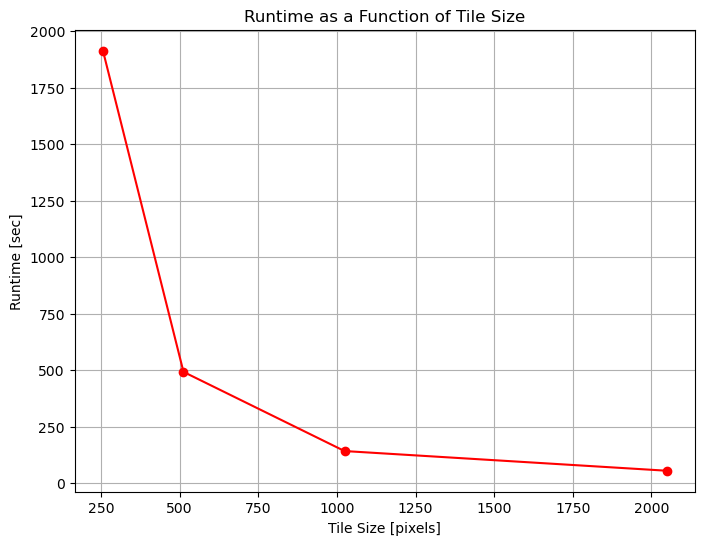

In [29]:
# Example data (replace with your actual data)
tile_sizes = x_test

runtimes = []
for time in times:
    runtime = (time[0] * 24 * 60 * 60) + (time[1] * 60 * 60) + (time[2] * 60) + time[3]
    runtimes.append(runtime)

# Create the dot plot with lines connecting the dots
plt.figure(figsize=(8, 6))

# Plot the lines connecting the dots
plt.plot(tile_sizes, runtimes, color='red', linestyle='-', marker='o')

# Add labels and title
plt.xlabel('Tile Size [pixels]')
plt.ylabel('Runtime [sec]')
plt.title('Runtime as a Function of Tile Size')

# Add grid
plt.grid(True)

# Show plot
plt.show()

Define the tile sizes to use in the future here. Make sure to adjust your settings.yaml accordinly.

In [19]:
x_step = 2048
y_step = 2048